In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import concatenate

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
import numpy as np
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

print(X_train.shape)


(60000, 28, 28, 1)


In [4]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [5]:
def GoogLeNet():
  # input layer
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(5, activation = 'softmax')(X1)


  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)


  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32,
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer
  X = Dropout(0.4)(X)

  # output layer
  X = Dense(10, activation = 'softmax')(X)

  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [6]:
model = GoogLeNet()

In [7]:
model.summary()

Model: "GoogLeNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 109, 109, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 54, 54, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 54, 54, 192)    │        110,784 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 26, 26, 192)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 26, 26, 96)     │         18,528 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 26, 26, 16)     │          3,088 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 26, 26, 192)    │              0 │ max_pooling2d_1[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 26, 26, 64)     │         12,352 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 26, 26, 128)    │        110,720 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 26, 26, 32)     │         12,832 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 26, 26, 32)     │          6,176 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 26, 26, 256)    │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 26, 26, 128)    │         32,896 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 26, 26, 32)     │          8,224 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 9,508,647 (36.27 MB)

 Trainable params: 9,508,647 (36.27 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy', 'accuracy', 'accuracy'])

In [9]:
batch_size =32

In [10]:
import cv2
def resizeimg(img):
  resize_img = cv2.resize(img, (224, 224))
  resize_img = np.stack((resize_img,)*3, axis = -1)
  return resize_img

In [11]:
def data(X, Y, batch_size):
  while True:

    for start in range(0, len(X), batch_size):
      end = min(start + batch_size, len(X_train))
      batch_X = X[start:end]
      batch_Y = Y[start:end]
      batch_X = np.array([resizeimg(img) for img in batch_X])
      yield batch_X, batch_Y

In [12]:
train = data(X_train[10000:], Y_train[10000:], batch_size)
test = data(X_test, Y_test, batch_size)
valid = data(X_train[:10000], Y_train[:10000], batch_size)
steps_per_epoch = len(X_train)//batch_size
validation_steps = len(X_train[:10000])//batch_size

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'dense_4_accuracy', patience = 3, verbose = 1, mode = 'max')
history = model.fit(train, steps_per_epoch = steps_per_epoch, epochs = 5, validation_data = valid, validation_steps = validation_steps, callbacks = [es])

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 264s 110ms/step - dense_4_accuracy: 0.6166 - loss: 1.0326 - val_dense_4_accuracy: 0.9743 - val_loss: 0.0887
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 182s 97ms/step - dense_4_accuracy: 0.9794 - loss: 0.0747 - val_dense_4_accuracy: 0.9838 - val_loss: 0.0566
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 178s 95ms/step - dense_4_accuracy: 0.9840 - loss: 0.0571 - val_dense_4_accuracy: 0.9811 - val_loss: 0.0933
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 178s 95ms/step - dense_4_accuracy: 0.9862 - loss: 0.0485 - val_dense_4_accuracy: 0.9882 - val_loss: 0.0450
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 177s 94ms/step - dense_4_accuracy: 0.9893 - loss: 0.0356 - val_dense_4_accuracy: 0.9884 - val_loss: 0.0427


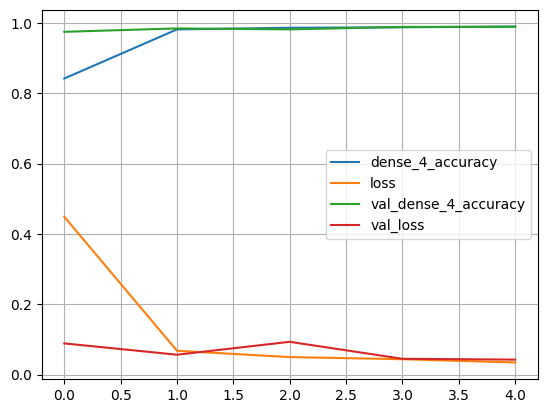

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

In [16]:
X_test, Y_test = next(test)
print(X_test.shape)
print(Y_test.shape)

(32, 224, 224, 3)
(32,)


In [22]:
print(model.evaluate(X_test, Y_test))
print(model.evaluate(X_test, Y_test))
proba_y = model.predict(X_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - dense_4_accuracy: 1.0000 - loss: 0.0114
[0.011410207487642765, 1.0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - dense_4_accuracy: 1.0000 - loss: 0.0114
[0.011410207487642765, 1.0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [24]:
proba_y[0]

array([[6.05529920e-15, 1.06199359e-12, 1.21583238e-11, 1.80895625e-16,
        2.08764065e-11, 5.69506283e-18, 9.14050814e-21, 1.00000000e+00,
        4.74010966e-16, 1.69107284e-09],
       [4.02446538e-08, 1.08857384e-04, 9.99886632e-01, 7.05792713e-09,
        1.88631528e-08, 9.12831546e-11, 4.44463740e-06, 1.38044132e-09,
        3.95673965e-08, 2.85394430e-10],
       [1.69881442e-08, 9.99997020e-01, 1.10336429e-09, 8.16932372e-12,
        3.42724718e-07, 3.17339621e-09, 2.49006035e-07, 2.40058876e-06,
        5.32947482e-08, 8.18779089e-09],
       [1.00000000e+00, 9.84807028e-11, 7.41289495e-12, 1.27239214e-14,
        3.26881473e-11, 4.97023733e-12, 1.95391925e-09, 9.20938889e-13,
        2.37794315e-11, 2.77515566e-10],
       [8.08314082e-10, 2.30364883e-08, 7.68985871e-08, 5.87579152e-11,
        9.99995232e-01, 9.92197879e-09, 1.87545215e-08, 9.93459466e-08,
        1.65192997e-08, 4.47118600e-06],
       [9.60104662e-10, 9.99998212e-01, 2.94856362e-11, 1.86404338e-14,
   

In [25]:
pred_y = np.argmax(proba_y[0], axis=1)

print(pred_y)

[7 2 1 0 4 1 4 9 5 9]


In [26]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(pred_y, Y_test[:10])
print(conf)

[[1 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 2]]


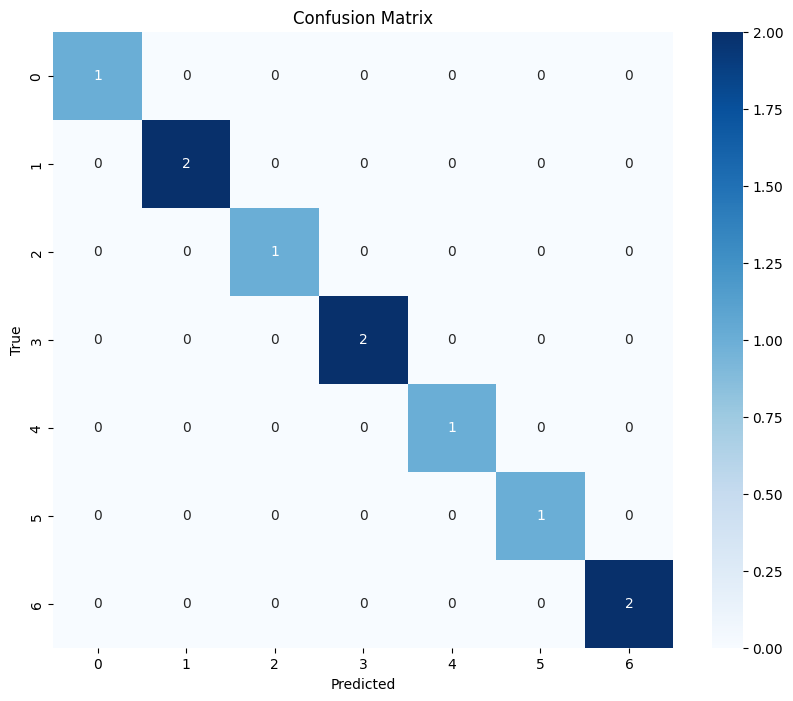

In [27]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()